In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [34]:
VIDEO_PATH = "/content/video3.mp4"

In [3]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.183 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [4]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

display.clear_output()

import sys
sys.path.append(f"{HOME}/ByteTrack")

import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [5]:
!pip install onnxruntime==1.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.3 MB/s eta 0:00:00


In [6]:
!pip install opencv-python

In [7]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [8]:
!pip install supervision==0.1.0

display.clear_output()

import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [9]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [10]:
from typing import List
import numpy as np

def boxformatting(detections: Detections) -> np.ndarray:
    """
    Convert detection information into a NumPy array with horizontally stacked columns.

    This function takes a Detections object and horizontally stacks the xyxy coordinates
    and confidence scores into a single NumPy array.

    Parameters:
    -----------
    detections : Type
        A Detections object containing xyxy coordinates and confidence scores.
        Replace 'Type' with the actual type of Detections if it's custom.

    Returns:
    --------
    np.ndarray
        A NumPy array with horizontally stacked columns containing xyxy coordinates
        and confidence scores.

    Example:
    --------
    >>> d = Detections(xyxy=[[1, 2, 3, 4], [5, 6, 7, 8]], confidence=[0.9, 0.8])
    >>> boxformatting(d)
    array([[1, 2, 3, 4, 0.9],
           [5, 6, 7, 8, 0.8]])
    """

    # Convert the detections of boxes and conf to a NumPy hstack
    converted = np.hstack((detections.xyxy, detections.confidence[:, np.newaxis]))
    return converted

In [11]:
def trackformatting(tracks: List[STrack]) -> np.ndarray:
    """
    Convert a list of STrack objects into a NumPy array containing their bounding box coordinates.

    This function takes a list of STrack objects, extracts the top-left and bottom-right coordinates
    of each track's bounding box, and stores them in a NumPy array.

    Parameters:
    -----------
    tracks : List[Type]
        A list of STrack objects, each containing a 'tlbr' attribute that represents the
        top-left and bottom-right coordinates of the bounding box.
        Replace 'Type' with the actual type of STrack if it's custom.

    Returns:
    --------
    np.ndarray
        A NumPy array containing the top-left and bottom-right coordinates of each track's
        bounding box. The dtype of the array is float.

    Example:
    --------
    >>> t1 = STrack(tlbr=[1, 2, 3, 4])
    >>> t2 = STrack(tlbr=[5, 6, 7, 8])
    >>> trackformatting([t1, t2])
    array([[1., 2., 3., 4.],
           [5., 6., 7., 8.]])
    """
    # Initialize an empty list to store track boxes
    track_boxes = []

    # Loop through each track in the list of tracks
    for track in tracks:
        # Get the top-left and bottom-right coordinates of the track
        tlbr = track.tlbr

        # Append the coordinates to the track_boxes list
        track_boxes.append(tlbr)

    # Convert the list of track boxes to a NumPy array with dtype=float
    track_boxes_array = np.array(track_boxes, dtype=float)

    return track_boxes_array


In [12]:
def dectect_track_matcher(detections: Detections, tracks: List[STrack]) -> Detections:
    """
    Match detections with tracks based on Intersection over Union (IoU) and return the corresponding track IDs.

    This function takes a list of Detections objects and a list of STrack objects, calculates the IoU
    between each detection and track, and assigns the track ID to the detection with the highest IoU.

    Parameters:
    -----------
    detections : Type
        A Detections object containing xyxy coordinates and confidence scores.
        Replace 'Type' with the actual type of Detections if it's custom.

    tracks : List[Type]
        A list of STrack objects, each containing a 'tlbr' attribute that represents the
        top-left and bottom-right coordinates of the bounding box and a 'track_id' attribute.
        Replace 'Type' with the actual type of STrack if it's custom.

    Returns:
    --------
    List[Union[int, None]] or np.ndarray
        A list containing the track IDs corresponding to each detection. If no match is found,
        the ID is set to None. If there are no detections or tracks, an empty NumPy array is returned.

    Example:
    --------
    >>> d = Detections(xyxy=[[1, 2, 3, 4], [5, 6, 7, 8]], confidence=[0.9, 0.8])
    >>> t1 = STrack(tlbr=[1, 2, 3, 4], track_id=1)
    >>> t2 = STrack(tlbr=[5, 6, 7, 8], track_id=2)
    >>> dectect_track_matcher(d, [t1, t2])
    [1, 2]
    """

    # Check if there are any detections and tracks; if not, return an empty array.
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    # Format the tracks for further calculations.
    formattedtracks = trackformatting(tracks=tracks)

    # Calculate the Intersection-over-Union (IoU) between each detection and track.
    iou = box_iou_batch(formattedtracks, detections.xyxy)

    # Find the index of the track with the highest IoU for each detection.
    track4detect = np.argmax(iou, axis=1)

    # Initialize a list to store the IDs of the best-matching tracks for each detection.
    ids = [None] * len(detections)

    # Assign track IDs to detections based on highest IoU.
    for id_index, detect_index in enumerate(track4detect):
        # Check if the IoU is not zero before assigning the ID.
        if iou[id_index, detect_index] != 0:
            ids[detect_index] = tracks[id_index].track_id

    # Return the list of IDs, one for each detection.
    return ids


In [32]:
# Selecting and setting up the model:
from ultralytics import YOLO
MODEL = "yolov8x.pt"
model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:01<00:00, 73.2MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients


In [14]:
# Showing classes
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [15]:
# Choosing the classes of interest (should not be nessary after transfer learning in the future)
CLASS_ID = [2, 3, 5, 7]

In [16]:
from sklearn.cluster import KMeans
import cv2

In [17]:
os.path.exists(VIDEO_PATH)

True


0: 384x640 12 cars, 4 trucks, 63.8ms
Speed: 3.8ms preprocess, 63.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


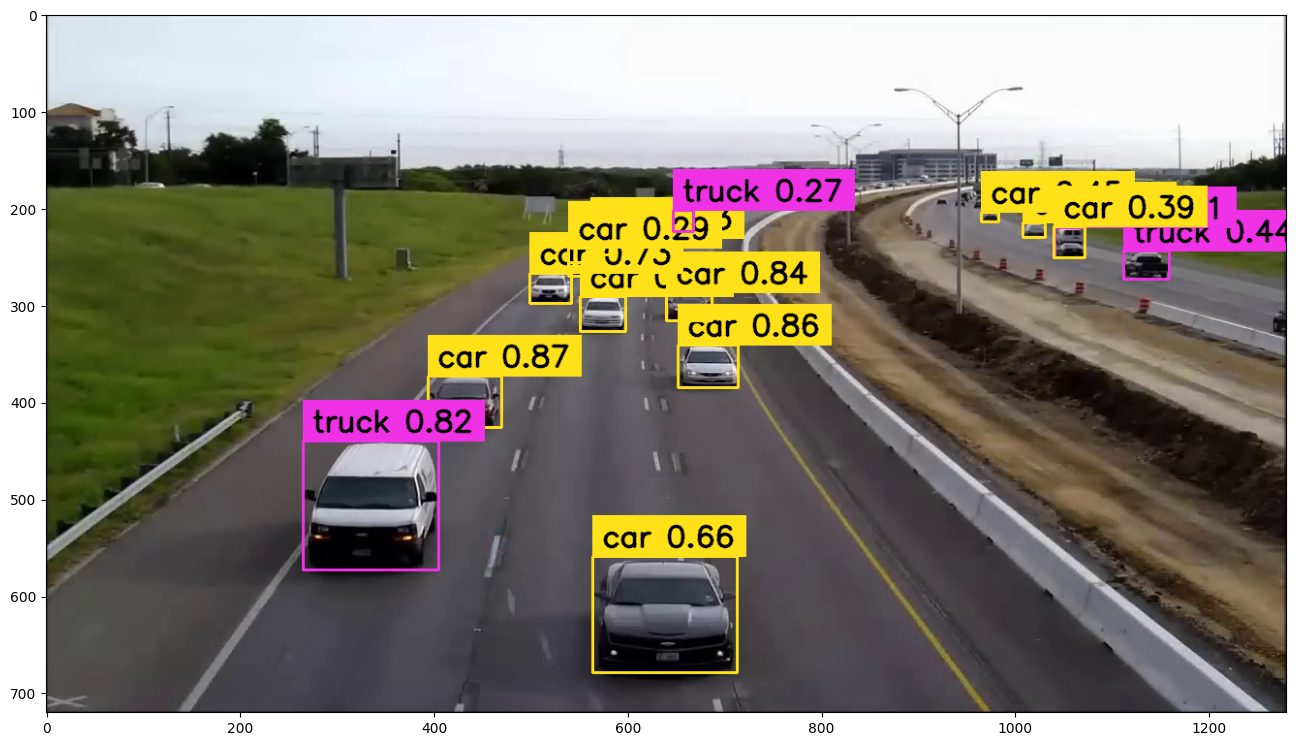

In [35]:
# Generate frames from video
generator = get_video_frames_generator(VIDEO_PATH)

# Init BoxAnnotator for annotating the frame with BBoxes
box_anno = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)

# Get first frame for testing:
frame = next(iter(generator))

# Prediction on first image
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

# Filtering out unwanted classes
mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
detections.filter(mask=mask, inplace=True)

# Formatting labels for frame
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# Snow frame with boxes
frame = box_anno.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))


0: 384x640 12 cars, 4 trucks, 63.2ms
Speed: 1.9ms preprocess, 63.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


[     652.39      341.76      714.22      385.54]
area:  2706.941475868225
Cropping area: (652.3880615234375, 341.7602233886719), (714.2196044921875, 385.5395202636719)
Dominant Color: [77 66 67]


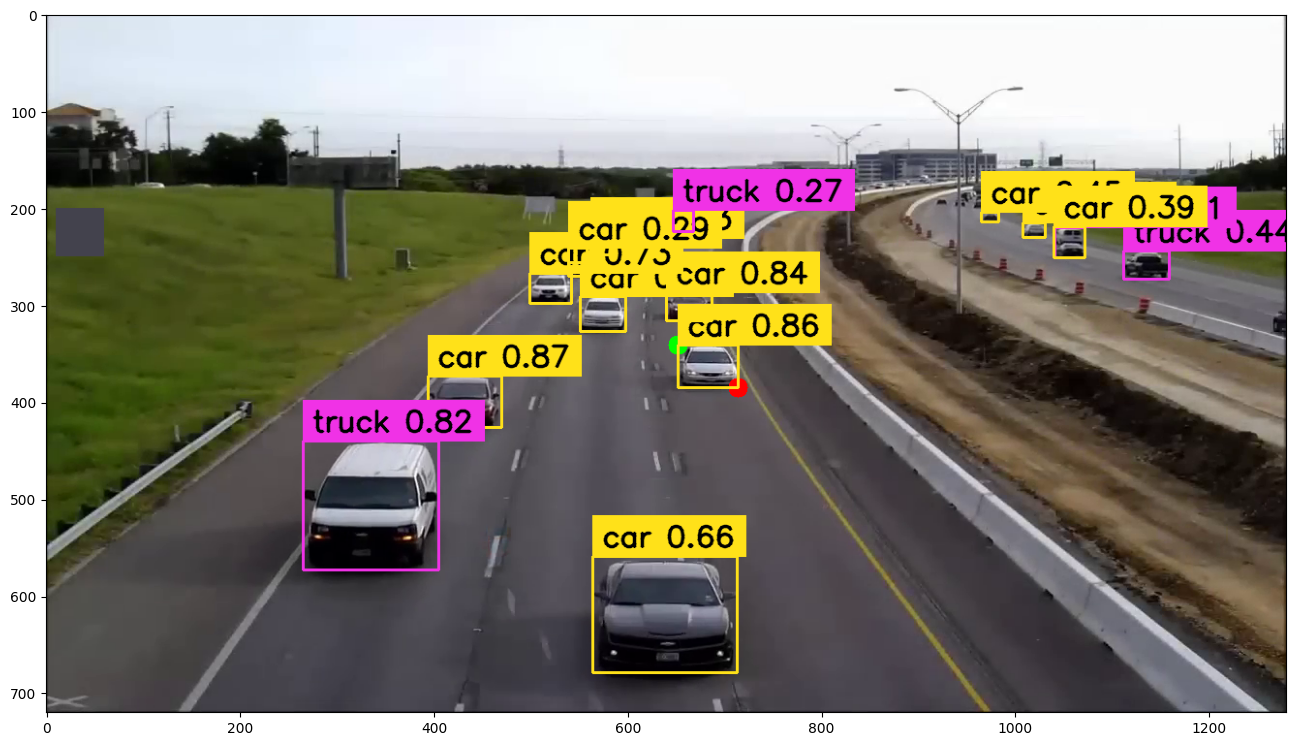

In [36]:
# Generate frames from video
generator = get_video_frames_generator(VIDEO_PATH)

# Init BoxAnnotator for annotating the frame with BBoxes
box_anno = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)

# Get first frame for testing:
frame = next(iter(generator))

# Prediction on first image
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

# Filtering out unwanted classes
mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
detections.filter(mask=mask, inplace=True)
truckxyxy = results[0].boxes.xyxy.cpu().numpy()[1]
print(truckxyxy)
x1, y1, x2, y2 = map(float, truckxyxy)
print("area: ", (x2-x1) * (y2 - y1))
print(f"Cropping area: ({x1}, {y1}), ({x2}, {y2})")

# Step 1: Crop the area
x1, y1, x2, y2 = map(int, truckxyxy)
cropped_area = frame[y1:y2, x1:x2]

# Step 2: Flatten the pixels
pixels = cropped_area.reshape(-1, 3)

# Step 3: Use KMeans to find the dominant color
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(pixels)
dominant_color = kmeans.cluster_centers_.astype(int)[0]

print(f"Dominant Color: {dominant_color}")

# Create a patch filled with the dominant color
patch_size = 50  # Size of the square patch
dominant_color_patch = np.zeros((patch_size, patch_size, 3), dtype=np.uint8)
dominant_color_patch[:, :, :] = dominant_color

# Position to overlay the patch on the frame
overlay_x = 10  # X-coordinate
overlay_y = 200  # Y-coordinate

# Overlay the dominant color patch onto the frame
frame[overlay_y:overlay_y+patch_size, overlay_x:overlay_x+patch_size] = dominant_color_patch


# Draw circles at (x1, y1) and (x2, y2)
circle_radius = 10  # You can change the radius as needed
color1 = (0, 255, 0)  # Green color in RGB
color2 = (0, 0, 255)  # Red color in RGB

# Draw the circles on the frame
cv2.circle(frame, (x1, y1), circle_radius, color1, -1)  # -1 means the circle will be filled
cv2.circle(frame, (x2, y2), circle_radius, color2, -1)  # -1 means the circle will be fille
# Formatting labels for frame
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# Snow frame with boxes
frame = box_anno.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))


0: 384x640 12 cars, 4 trucks, 63.4ms
Speed: 2.6ms preprocess, 63.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


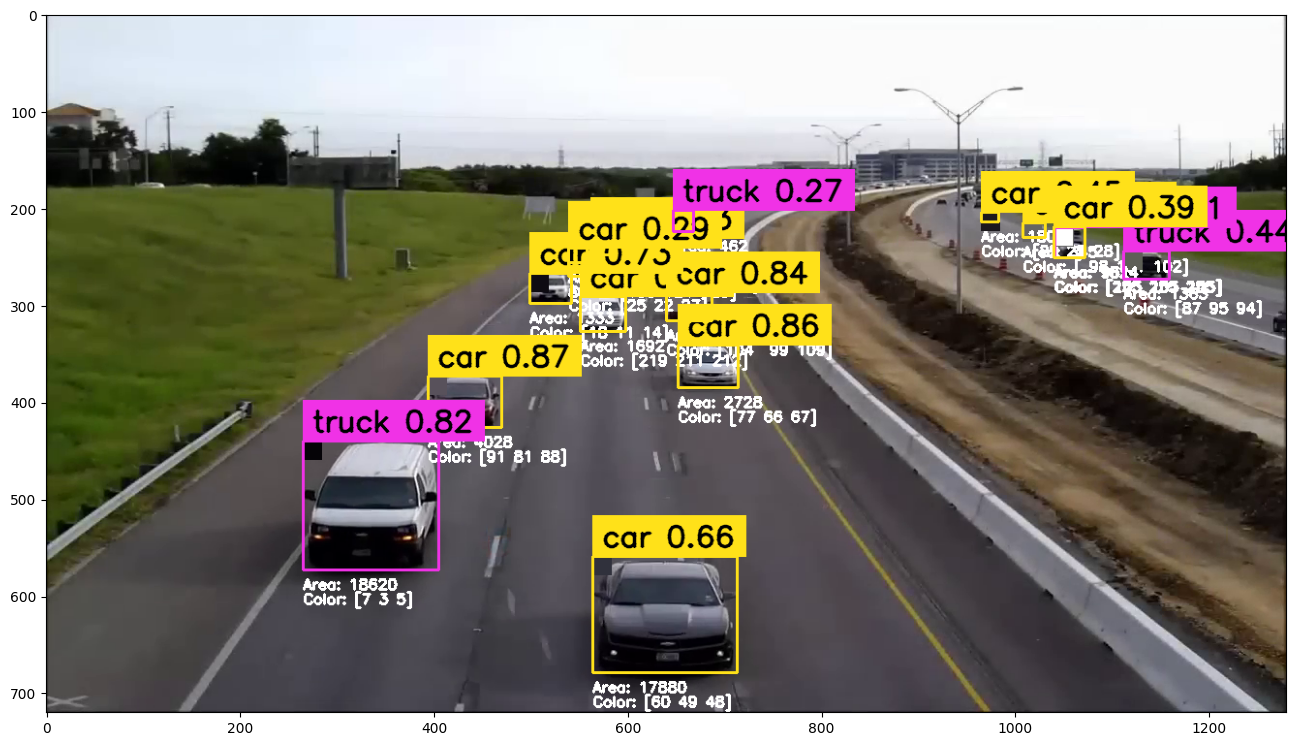

In [37]:
# Generate frames from video
generator = get_video_frames_generator(VIDEO_PATH)

# Init BoxAnnotator for annotating the frame with BBoxes
box_anno = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)

# Get first frame for testing:
frame = next(iter(generator))

# Prediction on first image
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

# Filtering out unwanted classes
mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
detections.filter(mask=mask, inplace=True)
for i in range(len(detections.xyxy)):
  # Calculate and show area:
  x1, y1, x2, y2 = map(int, detections.xyxy[i])
  area = (x2-x1) * (y2 - y1)
  cv2.putText(frame, f"Area: {area}", (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

  # Crop area to find dominant color
  cropped_area = frame[y1:y2, x1:x2]

  # Flatten the pixels
  pixels = cropped_area.reshape(-1, 3)

  # Use KMeans to find the dominant color
  kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(pixels)
  dominant_color = kmeans.cluster_centers_.astype(int)[0]

  # Show dominant color in RGB
  cv2.putText(frame, f"Color: {dominant_color}", (x1, y2 + 35), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

  # Create a patch filled with the dominant color
  patch_size = 20  # Size of the square patch
  dominant_color_patch = np.zeros((patch_size, patch_size, 3), dtype=np.uint8)
  dominant_color_patch[:, :, :] = dominant_color
  # Position to overlay the patch on the frame
  overlay_x = x1  # X-coordinate
  overlay_y = y1 # Y-coordinate

  # Overlay the dominant color patch onto the frame
  frame[overlay_y:overlay_y+patch_size, overlay_x:overlay_x+patch_size] = dominant_color_patch

# Formatting labels for frame
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# Snow frame with boxes
frame = box_anno.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))


0: 384x640 12 cars, 4 trucks, 63.3ms
Speed: 1.9ms preprocess, 63.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
<ipython-input-38-3e6596091da5>:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans.fit(pixels)


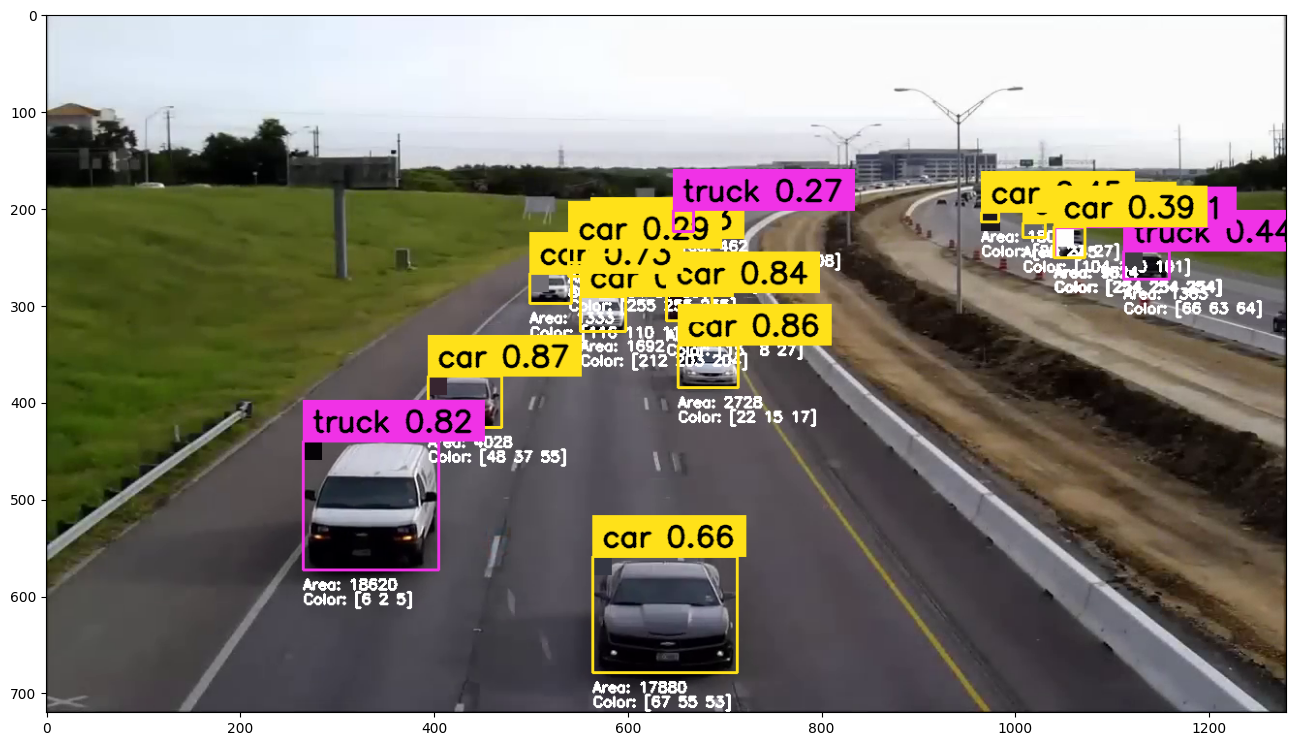

In [38]:
# Generate frames from video
generator = get_video_frames_generator(VIDEO_PATH)

# Init BoxAnnotator for annotating the frame with BBoxes
box_anno = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)

# Get first frame for testing:
frame = next(iter(generator))

# Prediction on first image
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

# Filtering out unwanted classes
mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
detections.filter(mask=mask, inplace=True)
for i in range(len(detections.xyxy)):
  # Calculate and show area:
  x1, y1, x2, y2 = map(int, detections.xyxy[i])
  area = (x2-x1) * (y2 - y1)
  cv2.putText(frame, f"Area: {area}", (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

  # Crop area to find dominant color
  cropped_area = frame[y1:y2, x1:x2]

  # Use GrabCut to segment the car
  mask = np.zeros(cropped_area.shape[:2], np.uint8)
  bgd_model = np.zeros((1, 65), np.float64)
  fgd_model = np.zeros((1, 65), np.float64)
  rect = (1, 1, cropped_area.shape[1]-1, cropped_area.shape[0]-1)
  cv2.grabCut(cropped_area, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

  # Use the mask to get pixels of the car only
  car_pixels = cropped_area * mask2[:, :, np.newaxis]

  # Flatten the pixels
  pixels = car_pixels.reshape(-1, 3)
  pixels = pixels[np.any(pixels != [0, 0, 0], axis=1)]  # Removing black pixels

  if len(pixels) == 0:
      print(f"No valid car pixels found for bounding box {i}. Skipping...")
      continue  # Skip to the next iteration

  # Use KMeans to find the dominant color
  kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(pixels)
  dominant_color = kmeans.cluster_centers_.astype(int)[0]

  # Show dominant color in RGB
  cv2.putText(frame, f"Color: {dominant_color}", (x1, y2 + 35), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

  # Create a patch filled with the dominant color
  patch_size = 20  # Size of the square patch
  dominant_color_patch = np.zeros((patch_size, patch_size, 3), dtype=np.uint8)
  dominant_color_patch[:, :, :] = dominant_color
  # Position to overlay the patch on the frame
  overlay_x = x1  # X-coordinate
  overlay_y = y1 # Y-coordinate

  # Overlay the dominant color patch onto the frame
  frame[overlay_y:overlay_y+patch_size, overlay_x:overlay_x+patch_size] = dominant_color_patch

# Formatting labels for frame
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# Snow frame with boxes
frame = box_anno.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [40]:
# settings
LINE_START = Point(0, 400)
LINE_END = Point(1280, 400)
VideoInfo.from_video_path(VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=29, total_frames=1744)

In [41]:
TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [42]:
from tqdm.notebook import tqdm
import cv2 # If we want to add visual progress

# Initatlize ByteTracker for tracking
tracker = BYTETracker(BYTETrackerArgs())

# Get VideoInfo from our source:
info = VideoInfo.from_video_path(VIDEO_PATH)

# Get frames from video
generator = get_video_frames_generator(VIDEO_PATH)

# Create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)

# Init BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=1)

# Main program
with VideoSink(TARGET_VIDEO_PATH, info) as sink:
  # Loop through the video frames
  for frame in tqdm(generator, total=info.total_frames):
    # Model prediction on current frame
    results = model(frame)
    detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )

    # Removeing the unwanted classes
    mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
    detections.filter(mask=mask, inplace=True)

    # Track the detection
    tracks = tracker.update(
        output_results=boxformatting(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracker_id = dectect_track_matcher(detections=detections, tracks=tracks)
    detections.tracker_id = np.array(tracker_id)

    # Removing detections without trackers
    mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
    detections.filter(mask=mask, inplace=True)

    for i in range(len(detections.xyxy)):
      # Calculate and show area:
      x1, y1, x2, y2 = map(int, detections.xyxy[i])
      area = (x2-x1) * (y2 - y1)
      cv2.putText(frame, f"Area: {area}", (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

      # If area > 4000 pixels^2, draw a rectangle inside the bounding box
      padding = 6
      if area > 4000:
          cv2.rectangle(frame, (x1 + padding, y1 + padding), (x2 - padding, y2 - padding), (0, 255, 0), 4) # Green rectangle
      else:
          cv2.rectangle(frame, (x1 + padding, y1 + padding), (x2 - padding, y2 - padding), (255, 0, 0), 4) # Green rectanglex

    # Formatting labels
    labels = [
    f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
    ]

    # Updating line counter
    line_counter.update(detections=detections)
    # Annotate and display frame
    frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
    line_annotator.annotate(frame=frame, line_counter=line_counter)
    sink.write_frame(frame)

  0%|          | 0/1744 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
0: 384x640 19 cars, 31.3ms
Speed: 1.7ms preprocess, 31.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 cars, 30.8ms
Speed: 2.0ms preprocess, 30.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 31.1ms
Speed: 1.9ms preprocess, 31.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 29.6ms
Speed: 6.5ms preprocess, 29.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 1 motorcycle, 30.1ms
Speed: 1.4ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 30.7ms
Speed: 1.8ms preprocess, 30.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 29.0ms
Speed: 1.8ms preprocess, 29.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 29.2ms
Speed: 1.7ms preprocess, 29.2ms i